In [ ]:
!pip install lazypredict-nightly > None

In [ ]:
import pandas as pd
import lazypredict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lazypredict import LazyRegressor
from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter1d
import lightgbm as lgb
import logging

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Loading the data
df = pd.read_csv('/content/Megy_final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1899 entries, 0 to 1898
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   space_group_core   1899 non-null   int64  
 1   space_group_shell  1899 non-null   int64  
 2   Tc                 1899 non-null   int64  
 3   x                  1899 non-null   float64
 4   y                  1899 non-null   float64
 5   z                  1899 non-null   float64
 6   shape              1899 non-null   int64  
 7   temperature_k      1899 non-null   float64
 8   h_range_max_koe    1899 non-null   float64
 9   sat_em_g           1899 non-null   float64
 10  coer_oe            1899 non-null   float64
 11  mr (emu/g)         1899 non-null   float64
 12  sphericity         1899 non-null   float64
 13  max/min            1899 non-null   float64
 14  area/volume        1899 non-null   float64
 15  num_of_magn_ions   1899 non-null   float64
 16  core_b             1899 

In [ ]:
df = df.drop(columns=['x', 'y', 'z', 'link', 'orig_c1', 'orig_c2'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1899 entries, 0 to 1898
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   space_group_core   1899 non-null   int64  
 1   space_group_shell  1899 non-null   int64  
 2   Tc                 1899 non-null   int64  
 3   shape              1899 non-null   int64  
 4   temperature_k      1899 non-null   float64
 5   h_range_max_koe    1899 non-null   float64
 6   sat_em_g           1899 non-null   float64
 7   coer_oe            1899 non-null   float64
 8   mr (emu/g)         1899 non-null   float64
 9   sphericity         1899 non-null   float64
 10  max/min            1899 non-null   float64
 11  area/volume        1899 non-null   float64
 12  num_of_magn_ions   1899 non-null   float64
 13  core_b             1899 non-null   float64
 14  core_alpha         1899 non-null   float64
 15  core_beta          1899 non-null   float64
 16  core_gamma         1899 

In [ ]:
# Preprocessing the target variable
y = df['coer_oe']
y = y[y > 0]  # Keep only positive values

# Logarithm of the smoothed target variable
y_log = np.log10(y)

# Forming the feature set
X = df[df['coer_oe'] > 0].drop(columns=['coer_oe'])

# Applying KNN Imputer to fill missing values
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_log, test_size=0.2, random_state=1984)

In [ ]:
# Set LightGBM to silent mode
lgb_params = {
    'verbose': -1,  # This will suppress most of the output
    'force_row_wise': True  # You can also add this to avoid overhead warning
}

# Additionally, suppress LightGBM logging explicitly
logger = logging.getLogger('lightgbm')
logger.setLevel(logging.ERROR)  # Only display errors

# Example LightGBM model call
model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train)

LGBMRegressor(force_row_wise=True, verbose=-1)

In [ ]:
# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating LazyRegressor
reg = LazyRegressor(predictions=True)
print("LazyRegressor created.")

LazyRegressor created.


In [ ]:
# Training and testing the models
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test)
print("Model fitting complete.")

100%|██████████| 42/42 [00:09<00:00,  4.35it/s]

Model fitting complete.


Models found.
Results saved to lazy_regressor_results.csv
Results loaded successfully from lazy_regressor_results.csv:
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.79       0.80  0.37        0.70
XGBRegressor                                 0.77       0.79  0.39        0.31
RandomForestRegressor                        0.76       0.78  0.40        1.38
BaggingRegressor                             0.74       0.75  0.42        0.16
HistGradientBoostingRegressor                0.73       0.74  0.43        0.30
LGBMRegressor                                0.72       0.74  0.43        0.13
ExtraTreeRegressor                           0.64       0.66  0.49        0.03
GradientBoostingRegressor                    0.58       0.60  0.53        0.51
KNeighborsRegressor                          0.57       0.60  0.53        0.02
MLPRegressor

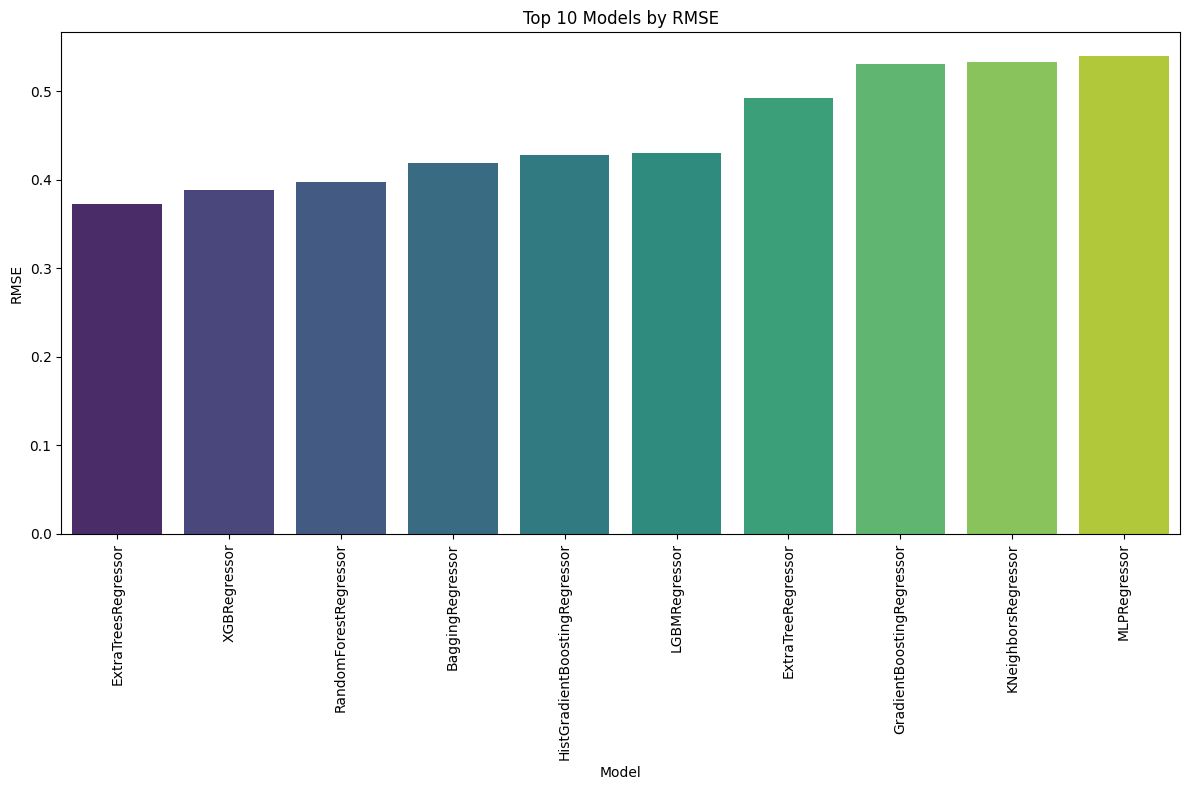

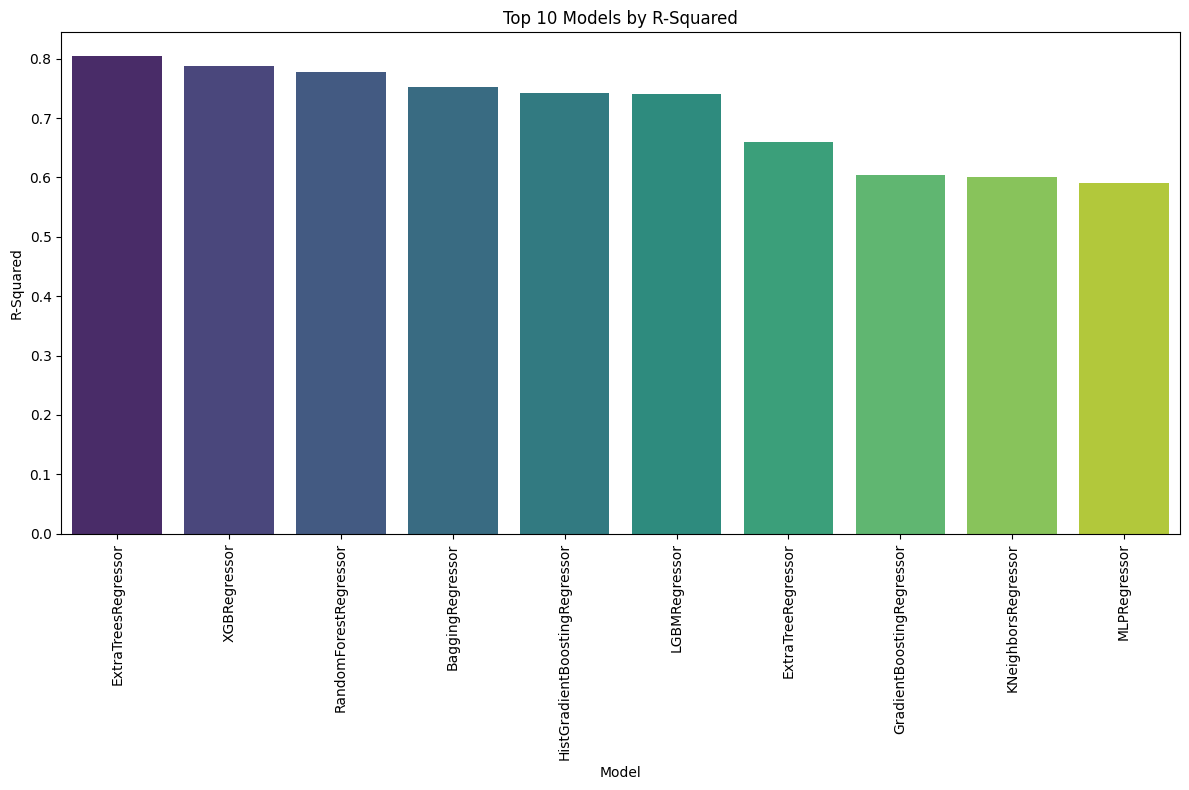

In [ ]:
# Checking the results
if not models.empty:
    print("Models found.")

    # Saving the results to a CSV file
    models.to_csv('lazy_regressor_results.csv', index=True)
    print("Results saved to lazy_regressor_results.csv")

    # Loading the results from the CSV file
    loaded_results = pd.read_csv('lazy_regressor_results.csv', index_col=0)
    print("Results loaded successfully from lazy_regressor_results.csv:")
    print(loaded_results)

    # Visualizing the top 10 models by RMSE
    plt.figure(figsize=(12, 8))
    top_10_rmse = models.sort_values(by='RMSE').head(10)
    sns.barplot(x=top_10_rmse.index, y='RMSE', data=top_10_rmse, palette='viridis')
    plt.xticks(rotation=90)
    plt.title('Top 10 Models by RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Model')
    plt.tight_layout()
    plt.show()

    # Visualizing the top 10 models by R-Squared
    plt.figure(figsize=(12, 8))
    top_10_r2 = models.sort_values(by='R-Squared', ascending=False).head(10)
    sns.barplot(x=top_10_r2.index, y='R-Squared', data=top_10_r2, palette='viridis')
    plt.xticks(rotation=90)
    plt.title('Top 10 Models by R-Squared')
    plt.ylabel('R-Squared')
    plt.xlabel('Model')
    plt.tight_layout()
    plt.show()
else:
    print("No models found.")